In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
#pd.set_option('precision', 3)

# Data Visualisation Libraries
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.set_style('darkgrid')

# Statistics
from scipy.stats import chi2_contingency
from imblearn.over_sampling import SMOTE

# Machine Learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import learning_curve

from sklearn.preprocessing import LabelEncoder, StandardScaler

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import accuracy_score, recall_score, precision_score, auc, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix

/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


In [2]:
font_size = 20
plt.rcParams['axes.labelsize'] = font_size
plt.rcParams['axes.titlesize'] = font_size + 2
plt.rcParams['xtick.labelsize'] = font_size - 2
plt.rcParams['ytick.labelsize'] = font_size - 2
plt.rcParams['legend.fontsize'] = font_size - 2

colors = ['#DD403A', '#00A5E0']
colors_cat = ['#E8907E', '#D5CABD', '#7A6F86', '#C34A36', '#B0A8B9', '#845EC2', '#8f9aaa', '#FFB86F', '#63BAAA', '#9D88B3', '#38c4e3']
colors_comp = ['steelblue', 'seagreen', 'black', 'darkorange', 'purple', 'firebrick', 'slategrey']

random_state = 42
scoring_metric = 'recall'
comparison_dict, comparison_test_dict = {}, {}

# Helper Functions

In [3]:
def plot_continuous(feature):
    '''Plot a histogram and boxplot for the churned and retained distributions for the specified feature.'''
    df_func = data.copy()
    df_func['POLICY_STATUS'] = df_func['POLICY_STATUS'].astype('category')

    fig, (ax1, ax2) = plt.subplots(2,
                                   figsize=(9, 7),
                                   sharex=True,
                                   gridspec_kw={'height_ratios': (.7, .3)})

    for df, color, label in zip([df_retained, df_churned], colors, ['Churned', 'Retained']):
        sns.histplot(data=df,
                     x=feature,
                     bins=15,
                     color=color,
                     alpha=0.66,
                     edgecolor='firebrick',
                     label=label,
                     kde=False,
                     ax=ax1)
    ax1.legend()

    sns.boxplot(x=feature, y='POLICY_STATUS', data=df_func, palette=colors, ax=ax2)
    ax2.set_ylabel('')
    ax2.set_yticklabels(['Churned', 'Retained'])

    plt.tight_layout()

In [4]:
def plot_conf_mx(cm, ax):
    '''Plot a confusion matrix in the specified axes object.'''
    sns.heatmap(data=cm,
                annot=True,
                cmap='Blues',
                annot_kws={'fontsize': 30},
                ax=ax)

    ax.set_xlabel('Predicted Label')
    ax.set_xticks([0.5, 1.5])
    ax.set_xticklabels(['Churned', 'Retained'])

    ax.set_ylabel('True Label')
    ax.set_yticks([0.25, 1.25])
    ax.set_yticklabels(['Churned', 'Retained'])

In [5]:
def plot_learning_curve(estimator,
                        X,
                        y,
                        ax,
                        cv=None,
                        train_sizes=np.linspace(0.1, 1.0, 5)):
    '''Plot the learning curves for an estimator in the specified axes object.'''
    train_sizes, train_scores, test_scores = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=-1,
        train_sizes=train_sizes,
        scoring='accuracy')

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    ax.fill_between(train_sizes,
                    train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std,
                    alpha=0.1,
                    color='dodgerblue')
    ax.fill_between(train_sizes,
                    test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std,
                    alpha=0.1,
                    color='darkorange')

    ax.plot(train_sizes,
            train_scores_mean,
            color='dodgerblue',
            marker='o',
            linestyle='-',
            label='Training Score')
    ax.plot(train_sizes,
            test_scores_mean,
            color='darkorange',
            marker='o',
            linestyle='-',
            label='Cross-validation Score')

    ax.set_xlabel('Training Examples')
    ax.set_ylabel('Score')
    ax.legend(loc='best', fontsize=14)

In [6]:
def clf_performance(classifier, classifier_name, classifier_name_abv):
    '''Display the overall performance of a classifier with this template.'''
    print('\n', classifier_name)
    print('-------------------------------')
    print('   Best Score ({}): '.format(scoring_metric) + str(np.round(classifier.best_score_, 3)))
    print('   Best Parameters: ')
    for key, value in classifier.best_params_.items():
        print('      {}: {}'.format(key, value))

    y_pred_pp = cross_val_predict(estimator=classifier.best_estimator_,
                                  X=X_train,
                                  y=y_train,
                                  cv=5,
                                  method='predict_proba')[:, 1]
    y_pred = y_pred_pp.round()

    cm = confusion_matrix(y_train, y_pred, normalize='true')

    fpr, tpr, _ = roc_curve(y_train, y_pred_pp)
    comparison_dict[classifier_name_abv] = [
        accuracy_score(y_train, y_pred),
        precision_score(y_train, y_pred),
        recall_score(y_train, y_pred),
        roc_auc_score(y_train, y_pred_pp), fpr, tpr
    ]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    plot_conf_mx(cm, ax1)
    plot_learning_curve(classifier.best_estimator_, X_train, y_train, ax2)

    plt.tight_layout()

In [7]:
def plot_feature_imp(classifier, classifier_name, color, ax):
    '''Plot the importance of features for a classifier as a barplot.'''
    importances = pd.DataFrame({'Feature': X_train.columns,
                                'Importance': np.round(classifier.best_estimator_.feature_importances_, 3)})

    importances = importances.sort_values('Importance', ascending=True).set_index('Feature')

    importances.plot.barh(color=color,
                          edgecolor='firebrick',
                          legend=False,
                          ax=ax)
    ax.set_title(classifier_name)
    ax.set_xlabel('Importance')

In [8]:
def test_func(classifier, classifier_name, ax):
    '''Assess the performance on the test set and plot the confusion matrix.'''
    y_pred = classifier.predict(X_test)
    cm = confusion_matrix(y_test, y_pred, normalize='true')

    comparison_test_dict[classifier_name] = [accuracy_score(y_test, y_pred),
                                             precision_score(y_test, y_pred),
                                             recall_score(y_test, y_pred)]

    sns.heatmap(cm,
                annot=True,
                annot_kws={'fontsize': 24},
                cmap='Blues',
                ax=ax)

    ax.set_title(classifier_name)

    ax.set_xlabel('Predicted Label')
    ax.set_xticks([0.5, 1.5])
    ax.set_xticklabels(['Retained', 'Churned'])

    ax.set_ylabel('True Label')
    ax.set_yticks([0.2, 1.4])
    ax.set_yticklabels(['Retained', 'Churned'])

# Import Data

In [9]:
data_path = "../input/car-insurance-oracle/data.csv"
df = pd.read_csv(data_path, parse_dates=["SYMB_END", "MHNET"])

/tmp/ipykernel_26/778434508.py:2: DtypeWarning: Columns (44) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path, parse_dates=["SYMB_END", "MHNET"])
/tmp/ipykernel_26/778434508.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(data_path, parse_dates=["SYMB_END", "MHNET"])


In [10]:
df['MHNET_DATE'] = pd.to_datetime(df['MHNET'], format='%Y%m')
df['SYMB_END'] = pd.to_datetime(df['SYMB_END'])
df['DAYS_TO_END'] = (df['SYMB_END'] - df['MHNET_DATE']).dt.days
#filtered_df = df[(df['DAY_DIFF'] >= 58)]
df = df.drop(columns=['MHNET_DATE'])

In [11]:
data = df
data.isnull().sum()

MHNET                             0
SYMB                              0
SYMB_START                        0
SYMB_END                          0
PAYMENT_END                       0
RENEWAL_SYMB                      0
CUSTOMER                          0
CUST_BIRTH_DATE               99017
GENDER                          333
CUST_ZIP_CODE                     0
AGENT_CD                          0
CDIE_AGENT_CD                     0
CGD_AGENT_CD                      0
CEMP_AGENT_CD                     0
CEP3_AGENT_CD                     0
TRPLHR                       619732
SYMB_DURATION                     0
NUM_ACTIVE_SYMB                   0
NUM_ACCIDENTS_INVOLVED            0
NUM_ACCIDENTS_RESP                0
NUM_ACCIDENTS_RESP_FR             0
NUM_ACCIDENTS_RESP_NOT_FR         0
NUM_ACCIDENTS_NOT_RESP            0
LOYALTY_PROGRAM                   0
NUM_VEHICLES                      0
CAR_BRAND                         0
CAR_MODEL                         0
CAR_PROD_YEAR               

In [12]:
data = data.drop_duplicates()

# Explr

Text(0, 0.5, 'Count')

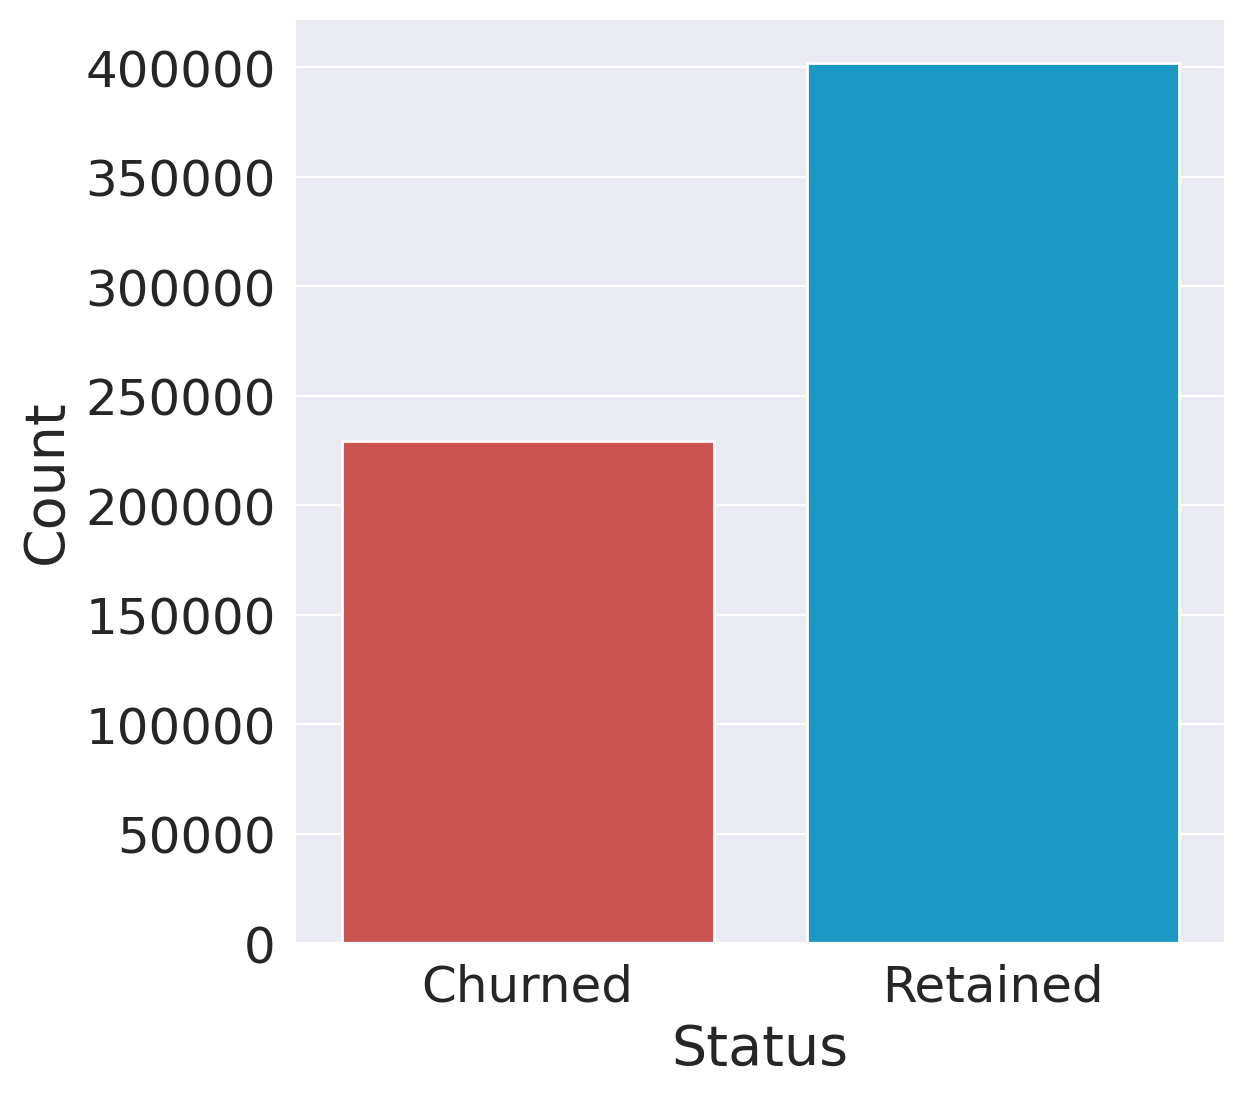

In [13]:
fig, ax = plt.subplots(figsize=(6, 6))

sns.countplot(x='POLICY_STATUS', data=data, palette=colors, ax=ax)

ax.set_xticklabels(['Churned', 'Retained'])
ax.set_xlabel('Status')
ax.set_ylabel('Count')

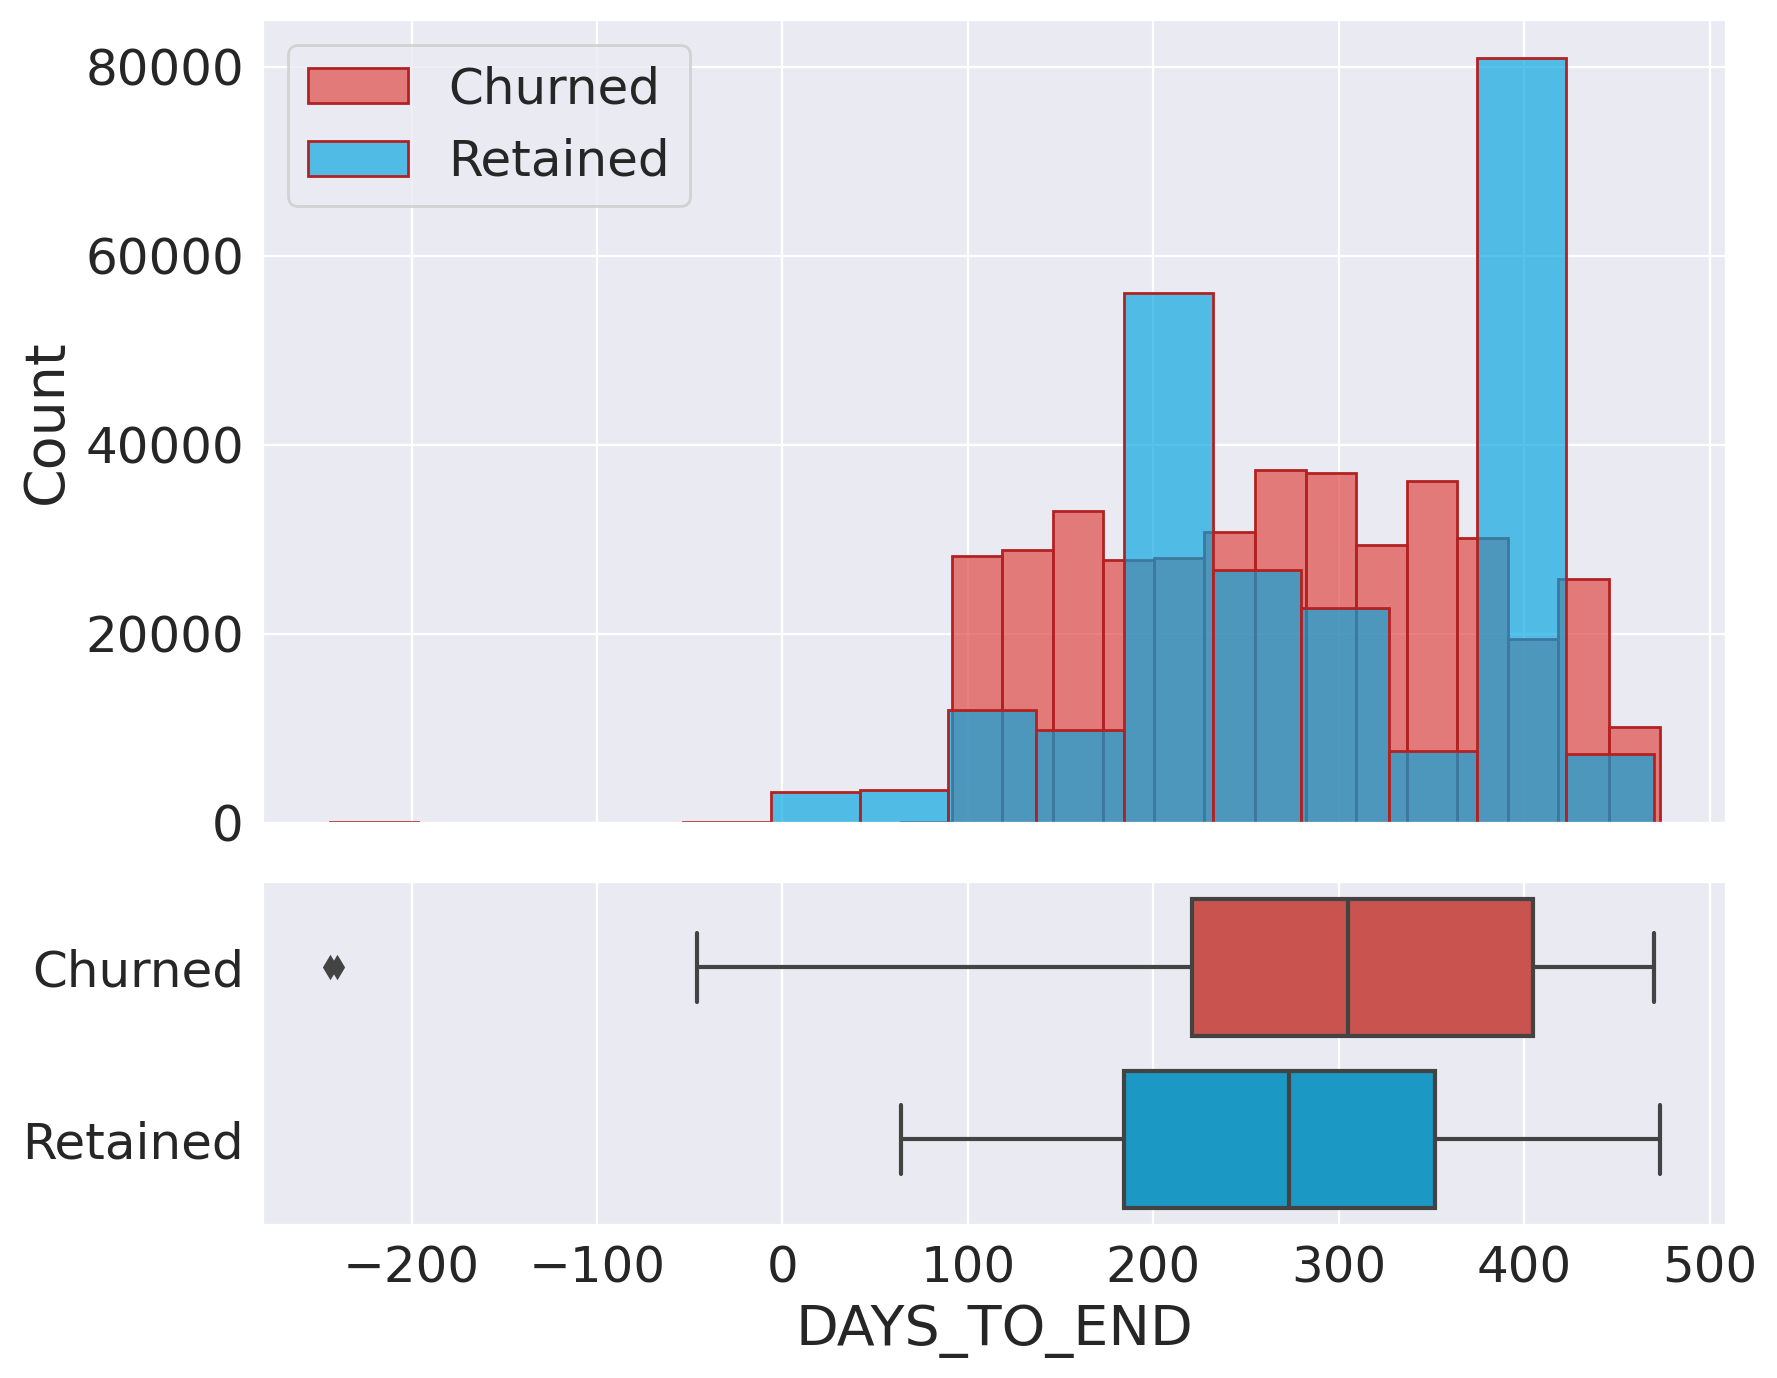

In [14]:
df_churned = data[data['POLICY_STATUS'] == 0]
df_retained = data[data['POLICY_STATUS'] == 1]

plot_continuous('DAYS_TO_END')

# Feature selection

Preliminary drop of features

In [15]:
# Has NaN values across almost the whole dataset
data = data.drop(columns=["TRPLHR"])

# Reference date and contract number are not required
data = data.drop(columns=["MHNET", "SYMB"])

# Do not need customer code
data = data.drop(columns=["CUSTOMER"])

# Remove all agent ids
data = data.drop(columns=["AGENT_CD", "CDIE_AGENT_CD", "CGD_AGENT_CD",
                          "CEMP_AGENT_CD", "CEP3_AGENT_CD"]
                )

In [16]:
categorical = [
    'ACCEPT_EMAIL', 'CEPAG', 'CAR_USAGE', 'POLICY_STATUS', 'EIDOS_PER', 
    'LOYALTY_PROGRAM', 'IS_STANDING_ORDER', 'HAS_RETURNED', 
    'CAR_BRAND', 'ACCEPT_SMS', 'TROPOS_EXOFL', 'INS_PACKAGE', 
    'TAXK_INC_ZONE_NAME', 'GENDER', 'CAR_MODEL', 'IS_RENEWAL', 
    'AGENT_CATG', 'CAR_INVC_ZONE', 'BONUS_MALUS', 'NEW_PREMIUM', 'OLD_PREMIUM'
]

continuous = [
    'NUM_COVERAGES', 'CLAIMS_AMOUNT', 'NUM_ACCIDENTS_RESP', 
    'NUM_ACCIDENTS_RESP_FR', 'SYMB_DURATION', 'NUM_ACTIVE_SYMB', 
    'NUM_ACCIDENTS_RESP_NOT_FR', 'CAR_PROD_YEAR', 'PENDING_AMOUNT', 
    'DISCOUNT_AMOUNT', 'CAR_AGE', 
    'ASFAL_AMOUNT', 'TOTAL_YEAR_INSURED_SYMB', 'CAR_CAPACITY', 
    'PREMIUM_PRICE', 'NUM_COMPLAINTS', 'NUM_ACCIDENTS_NOT_RESP', 
    'LOSS_RATIO', 'PAID_AMOUNT', 'CUST_BIRTH_DATE', 'SYMB_START',
    'SYMB_END', 'NEW_PREMIUM_PRICE', 'CUST_ZIP_CODE', 'NUM_ACCIDENTS_INVOLVED',
    'PAYMENT_END', 'RENEWAL_SYMB', 'NUM_VEHICLES', 'DAYS_TO_END'
]

assert not set(categorical) & set(continuous), "Reality check."

### Intuition
LOYALTY_PROGRAM: Indicates customer engagement; high engagement reduces churn risk.

IS_RENEWAL: At renewal, customers decide to stay or leave, crucial for churn prediction.

HAS_RETURNED: Returning customers may have different loyalty and satisfaction levels.

CAR_USAGE: Influences the perceived value of service, affecting churn.

In [17]:
retained_categorical = [
    'LOYALTY_PROGRAM',
    'IS_RENEWAL',
    'HAS_RETURNED',
    'CAR_USAGE'
]

dropped_categorical = [
    'ACCEPT_EMAIL',
    'CEPAG',
    'CAR_BRAND',
    'ACCEPT_SMS',
    'TROPOS_EXOFL',
    'INS_PACKAGE',
    'TAXK_INC_ZONE_NAME',
    'GENDER',
    'CAR_MODEL',
    'AGENT_CATG',
    'CAR_INVC_ZONE',
    'BONUS_MALUS',
    'NEW_PREMIUM',
    'OLD_PREMIUM',
    'EIDOS_PER',
    'IS_STANDING_ORDER'
]

In [18]:
data = data.drop(dropped_categorical, axis=1)

Keep only month aspect from dates

In [19]:
data['CUST_BIRTH_DATE'] = pd.to_datetime(data['CUST_BIRTH_DATE'], errors='coerce').dt.year
data['SYMB_START'] = pd.to_datetime(data['SYMB_START'], errors='coerce').dt.month
data['SYMB_END'] = pd.to_datetime(data['SYMB_END'], errors='coerce').dt.month
data['PAYMENT_END'] = pd.to_datetime(data['PAYMENT_END'], errors='coerce').dt.month
data['RENEWAL_SYMB'] = pd.to_datetime(data['RENEWAL_SYMB'], errors='coerce').dt.month

In [20]:
data = data.dropna()

Scale continuous features

In [21]:
scaler = StandardScaler()

data[continuous] = scaler.fit_transform(data[continuous])

In [22]:
y_data = data['POLICY_STATUS']
X_data = data.drop(columns=['POLICY_STATUS'])

In [23]:
print(X_data.shape, y_data.shape)

(519668, 33) (519668,)


In [24]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data,
                                                    test_size=0.2,
                                                    random_state=random_state)

### Address class imbalance
Used SMOTE ('Synthetic Minority Oversampling Technique') algorithm, which
'*finds a record that is similar to the record being upsampled and creates a synthetic record that is a randomly weighted average of the original record and the neighbouring record, where the weight is generated separately for each predictor*'

**[Practical Statistics for Data Scientists, 2nd Edition](https://www.oreilly.com/library/view/practical-statistics-for/9781492072935/), by Peter Bruce, Andrew Bruce, and Peter Gedeck (2020)**


In [25]:
over = SMOTE(sampling_strategy='auto', random_state=random_state)
X_train, y_train = over.fit_resample(X_train, y_train)

y_train.value_counts()

POLICY_STATUS
0    259319
1    259319
Name: count, dtype: int64

# Some machine learning models

## Tuning

Logistic regression

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c


 Logistic Regression
-------------------------------
   Best Score (recall): 0.901
   Best Parameters: 
      C: 0.001
      max_iter: 100
      penalty: l2
      solver: liblinear


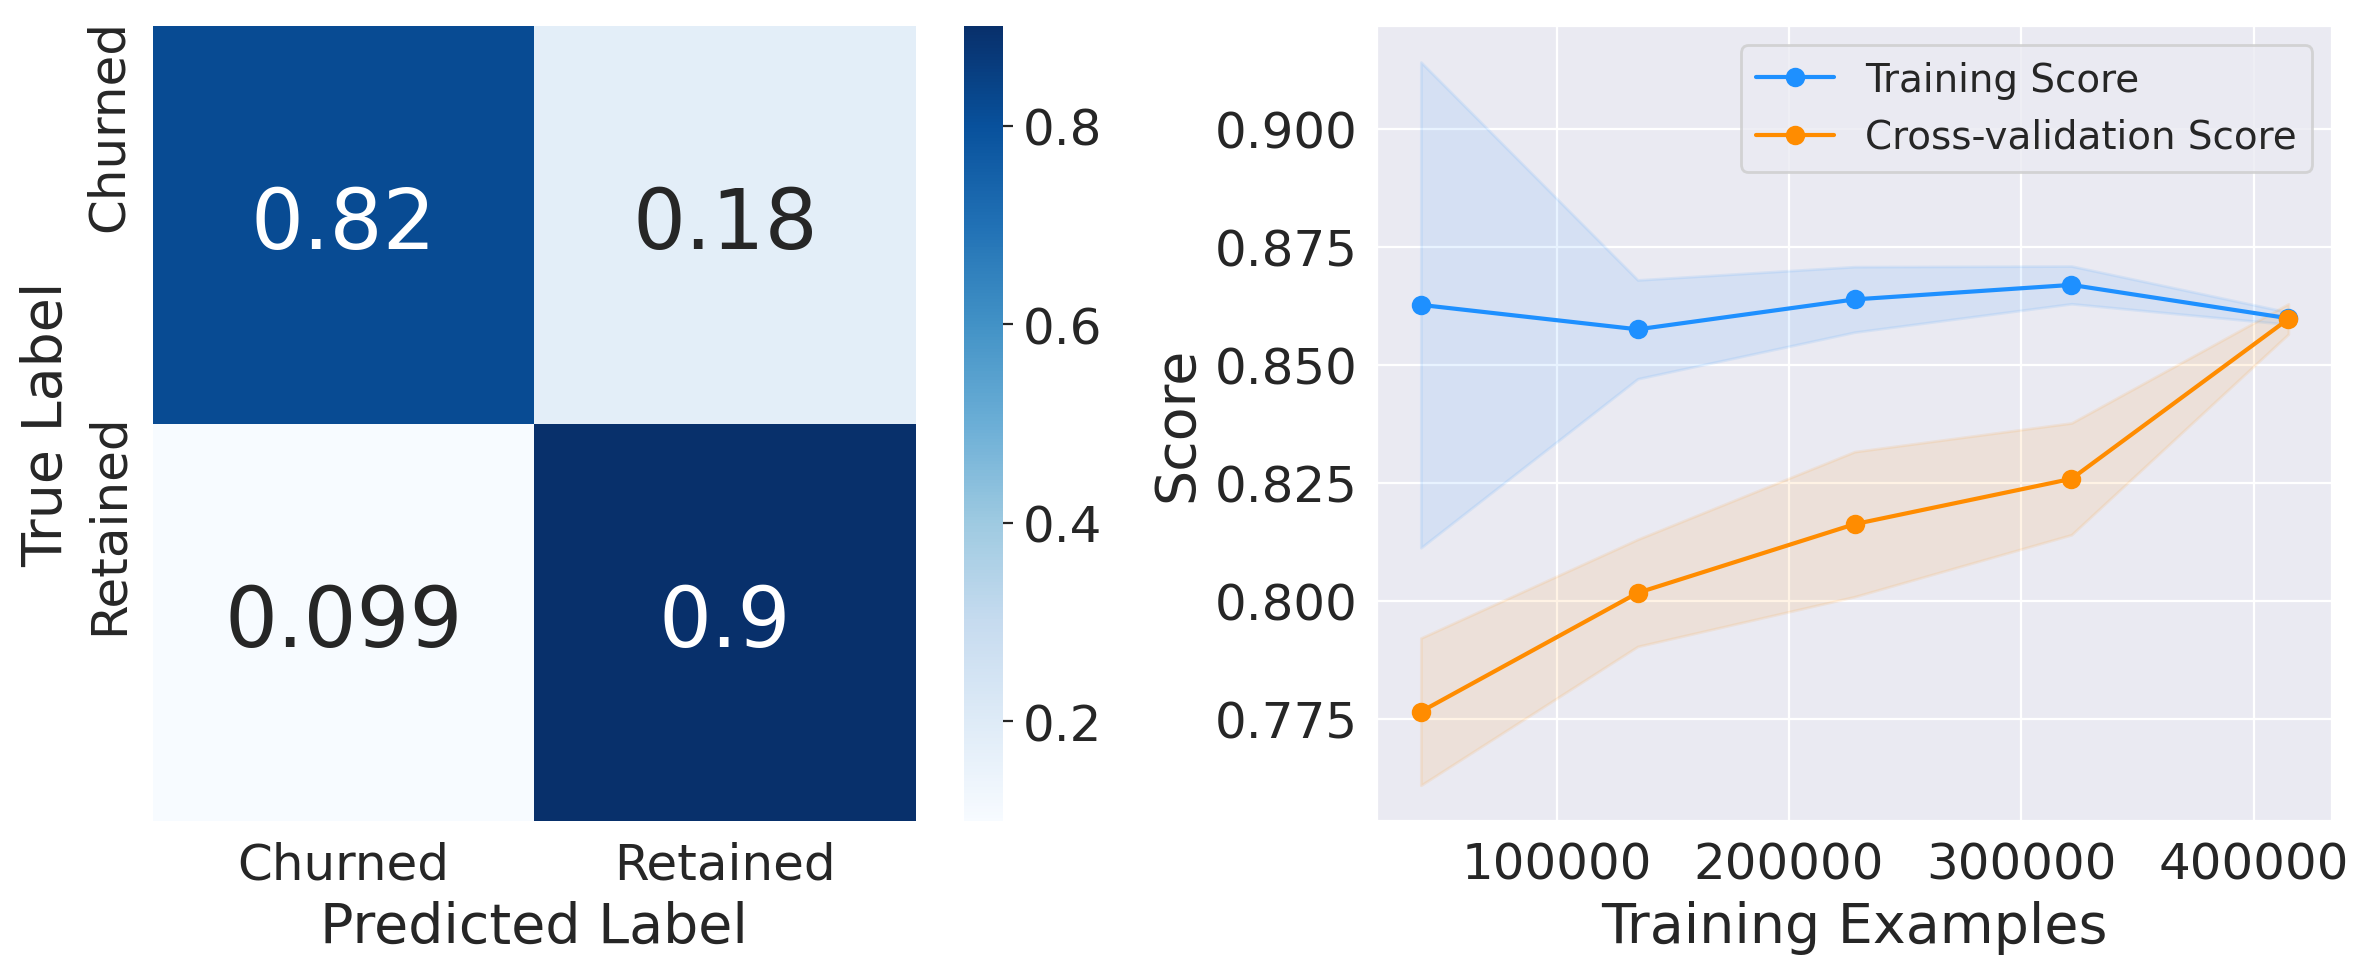

In [26]:
lr = LogisticRegression(random_state=random_state)

param_grid = {
    'max_iter': [100],
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1],
    'solver': ['lbfgs', 'liblinear']
}

lr_clf = GridSearchCV(estimator=lr,
                      param_grid=param_grid,
                      scoring=scoring_metric,
                      cv=5,
                      verbose=False,
                      n_jobs=-1)

best_lr_clf = lr_clf.fit(X_train, y_train)
clf_performance(best_lr_clf, 'Logistic Regression', 'LR')

Random forest


 Random Forest
-------------------------------
   Best Score (recall): 0.992
   Best Parameters: 
      bootstrap: True
      criterion: entropy
      max_depth: 5
      min_samples_split: 2
      n_estimators: 20


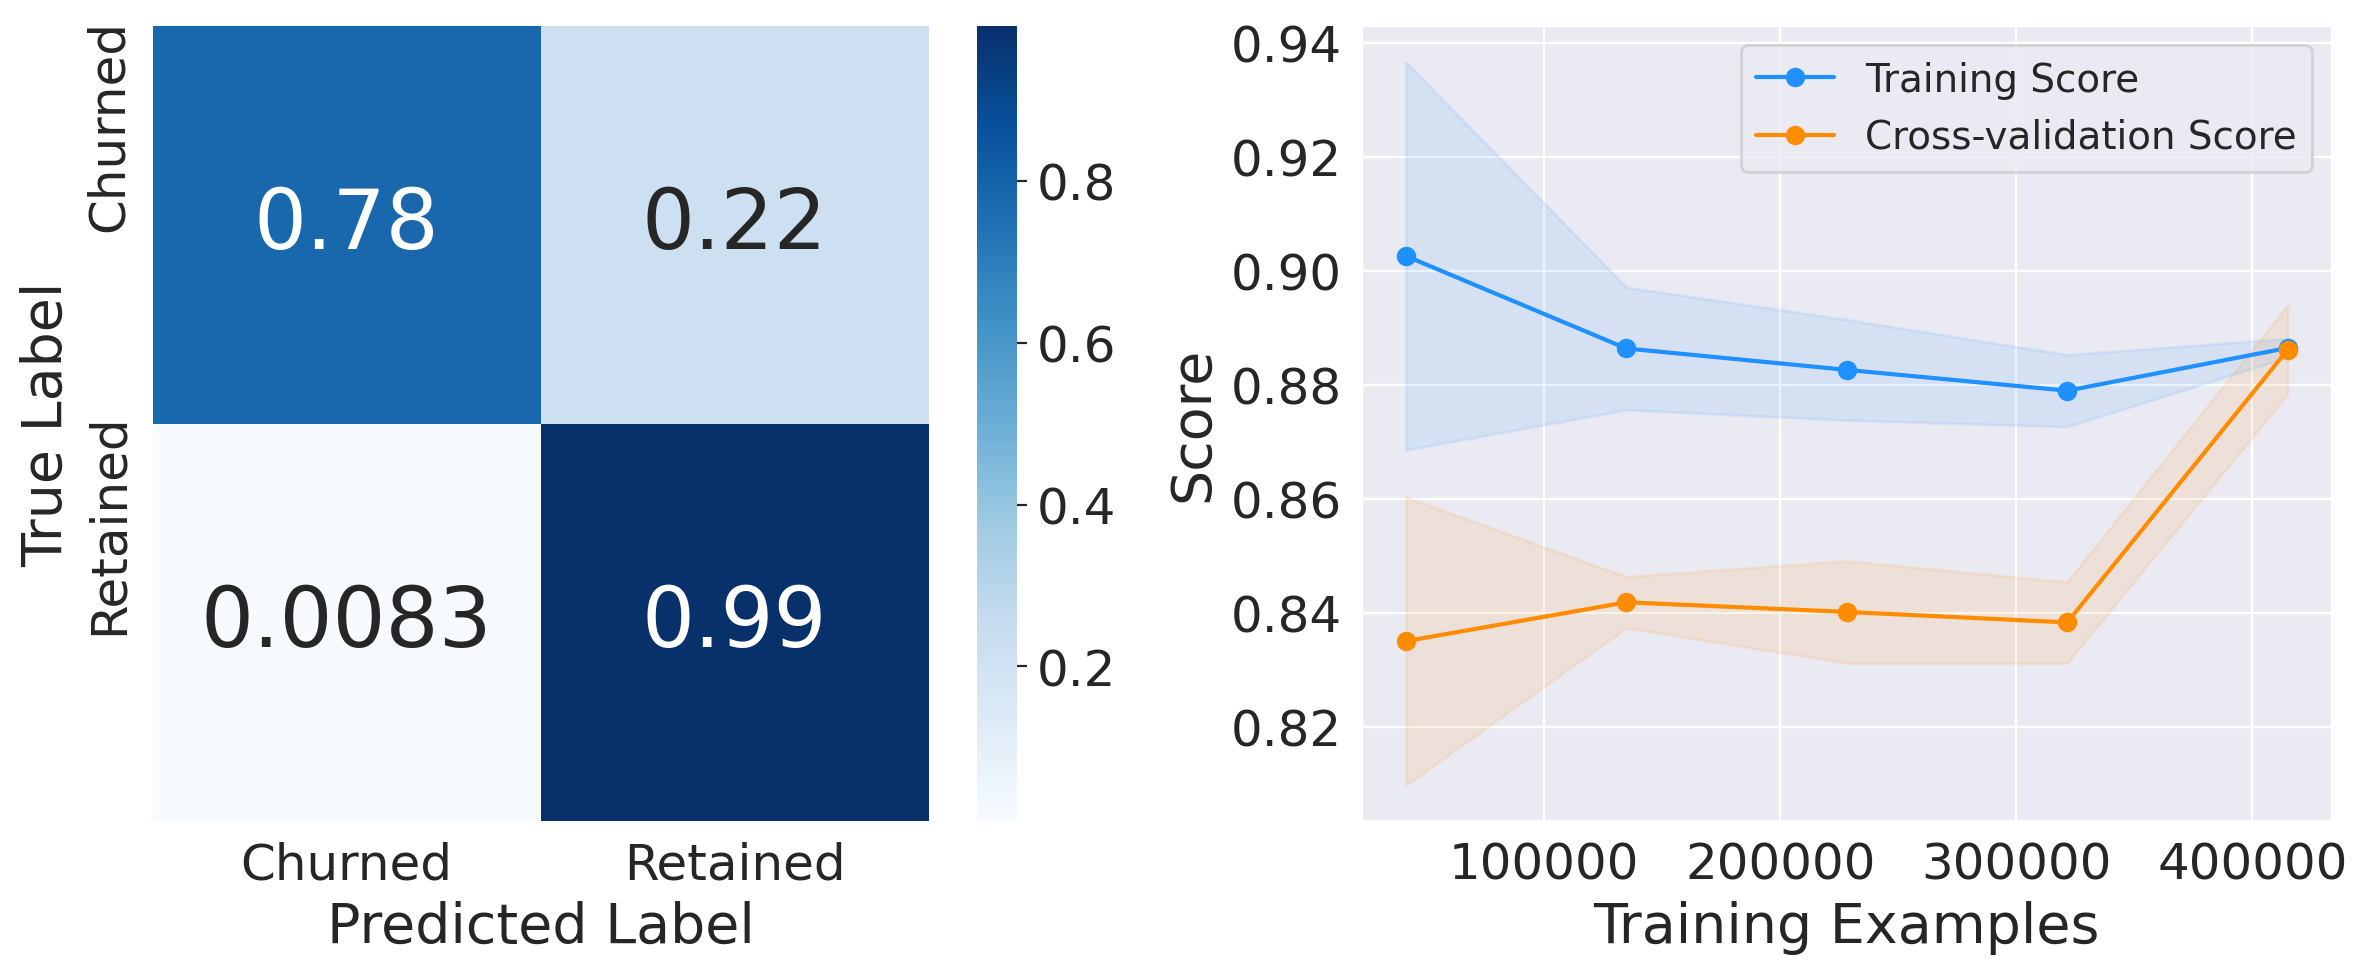

In [27]:
rf = RandomForestClassifier(random_state=random_state)
param_grid = {
    'n_estimators': [20],
    'criterion': ['entropy', 'gini'],
    'max_depth': [5],
    'bootstrap': [True, False],
    'min_samples_split': [2, 5],
    'min_samples_split': [2, 3, 5]
}

rf_clf = GridSearchCV(estimator=rf,
                      param_grid=param_grid,
                      scoring=scoring_metric,
                      cv=5,
                      verbose=False,
                      n_jobs=-1)

best_rf_clf = rf_clf.fit(X_train, y_train)
clf_performance(best_rf_clf, 'Random Forest', 'RF')

LGBMClassifier

/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current versio

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Info] Number of positive: 207456, number of negative: 207455
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 6094
[LightGBM] [Info] Number of data points in the train set: 414911, number of used features: 33
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 17 dense feature groups (7.91 MB) transferred to GPU in 0.042058 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500001 -> initscore=0.000005
[LightGBM] [Info] Start training from score 0.000005
[LightGBM] [Warning] f

/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Info] Number of positive: 207455, number of negative: 207455
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 6223
[LightGBM] [Info] Number of data points in the train set: 414910, number of used features: 33
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 17 dense feature groups (7.91 MB) transferred to GPU in 0.020418 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will

/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current versio

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Info] Number of positive: 207455, number of negative: 207456
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 6031
[LightGBM] [Info] Number of data points in the train set: 414911, number of used features: 33
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 17 dense feature groups (7.91 MB) transferred to GPU in 0.059916 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499999 -> initscore=-0.000005
[LightGBM] [Info] Start training from score -0.000005
[LightGBM] [Warning]

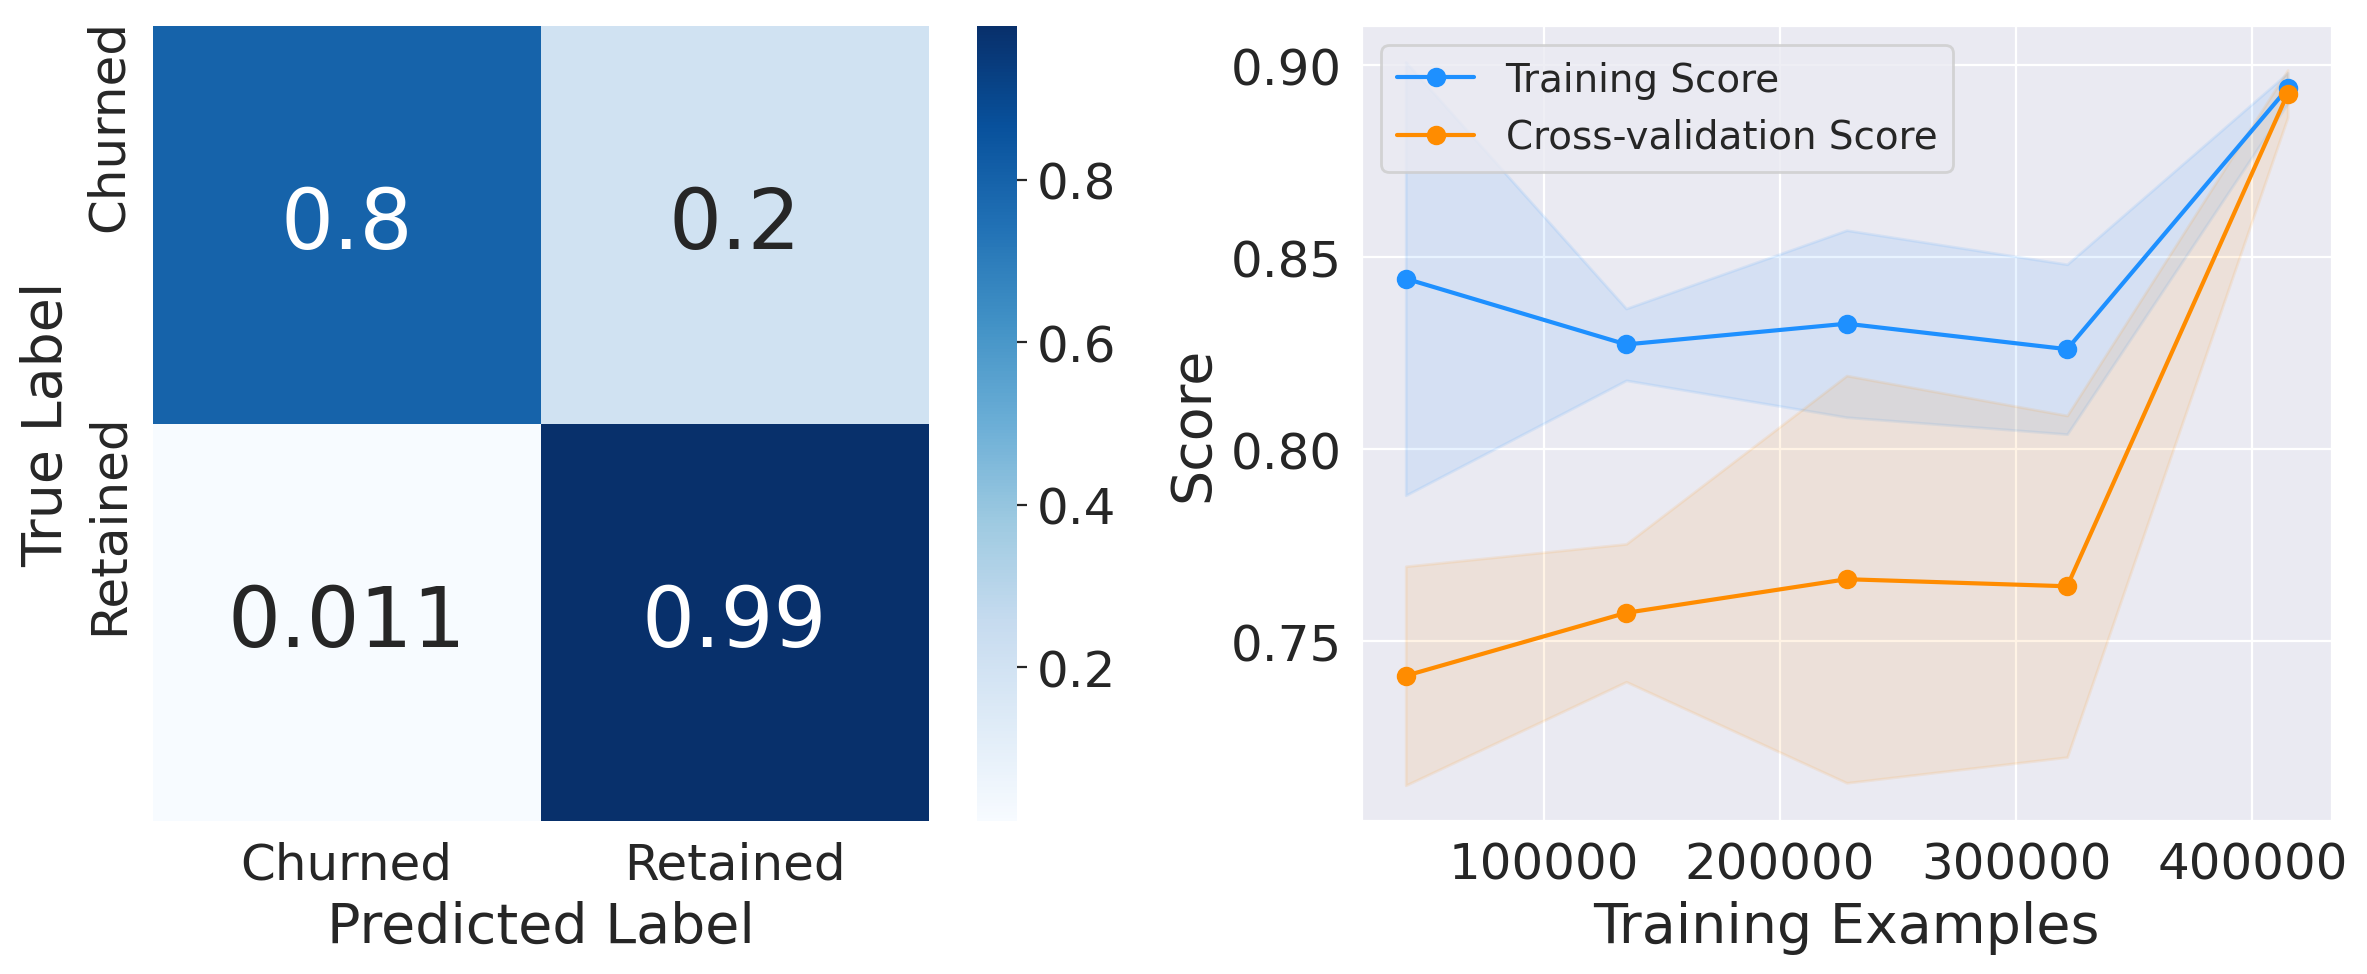

In [28]:
lgbmc = LGBMClassifier(random_state=random_state)

param_grid = {
    'max_depth': [5],
    'num_leaves': [5],
    'learning_rate': [0.001, 0.01],
    'n_estimators': [100],
    'feature_fraction': [0.5],
    'min_child_samples': [5, 10],
    'reg_alpha': [0.1, 0.5],
    'reg_lambda': [0.1, 0.5],
    'device': ['gpu']
}

lgbmc_clf = GridSearchCV(estimator=lgbmc,
                         param_grid=param_grid,
                         scoring=scoring_metric,
                         cv=5,
                         verbose=False,
                         n_jobs=-1)

best_lgbmc_clf = lgbmc_clf.fit(X_train, y_train)
clf_performance(best_lgbmc_clf, 'LGBMClassifier', 'LGBMC')

Feature importance

/tmp/ipykernel_26/3453497584.py:8: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(2, 2, i + 1)
/tmp/ipykernel_26/3453497584.py:8: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(2, 2, i + 1)


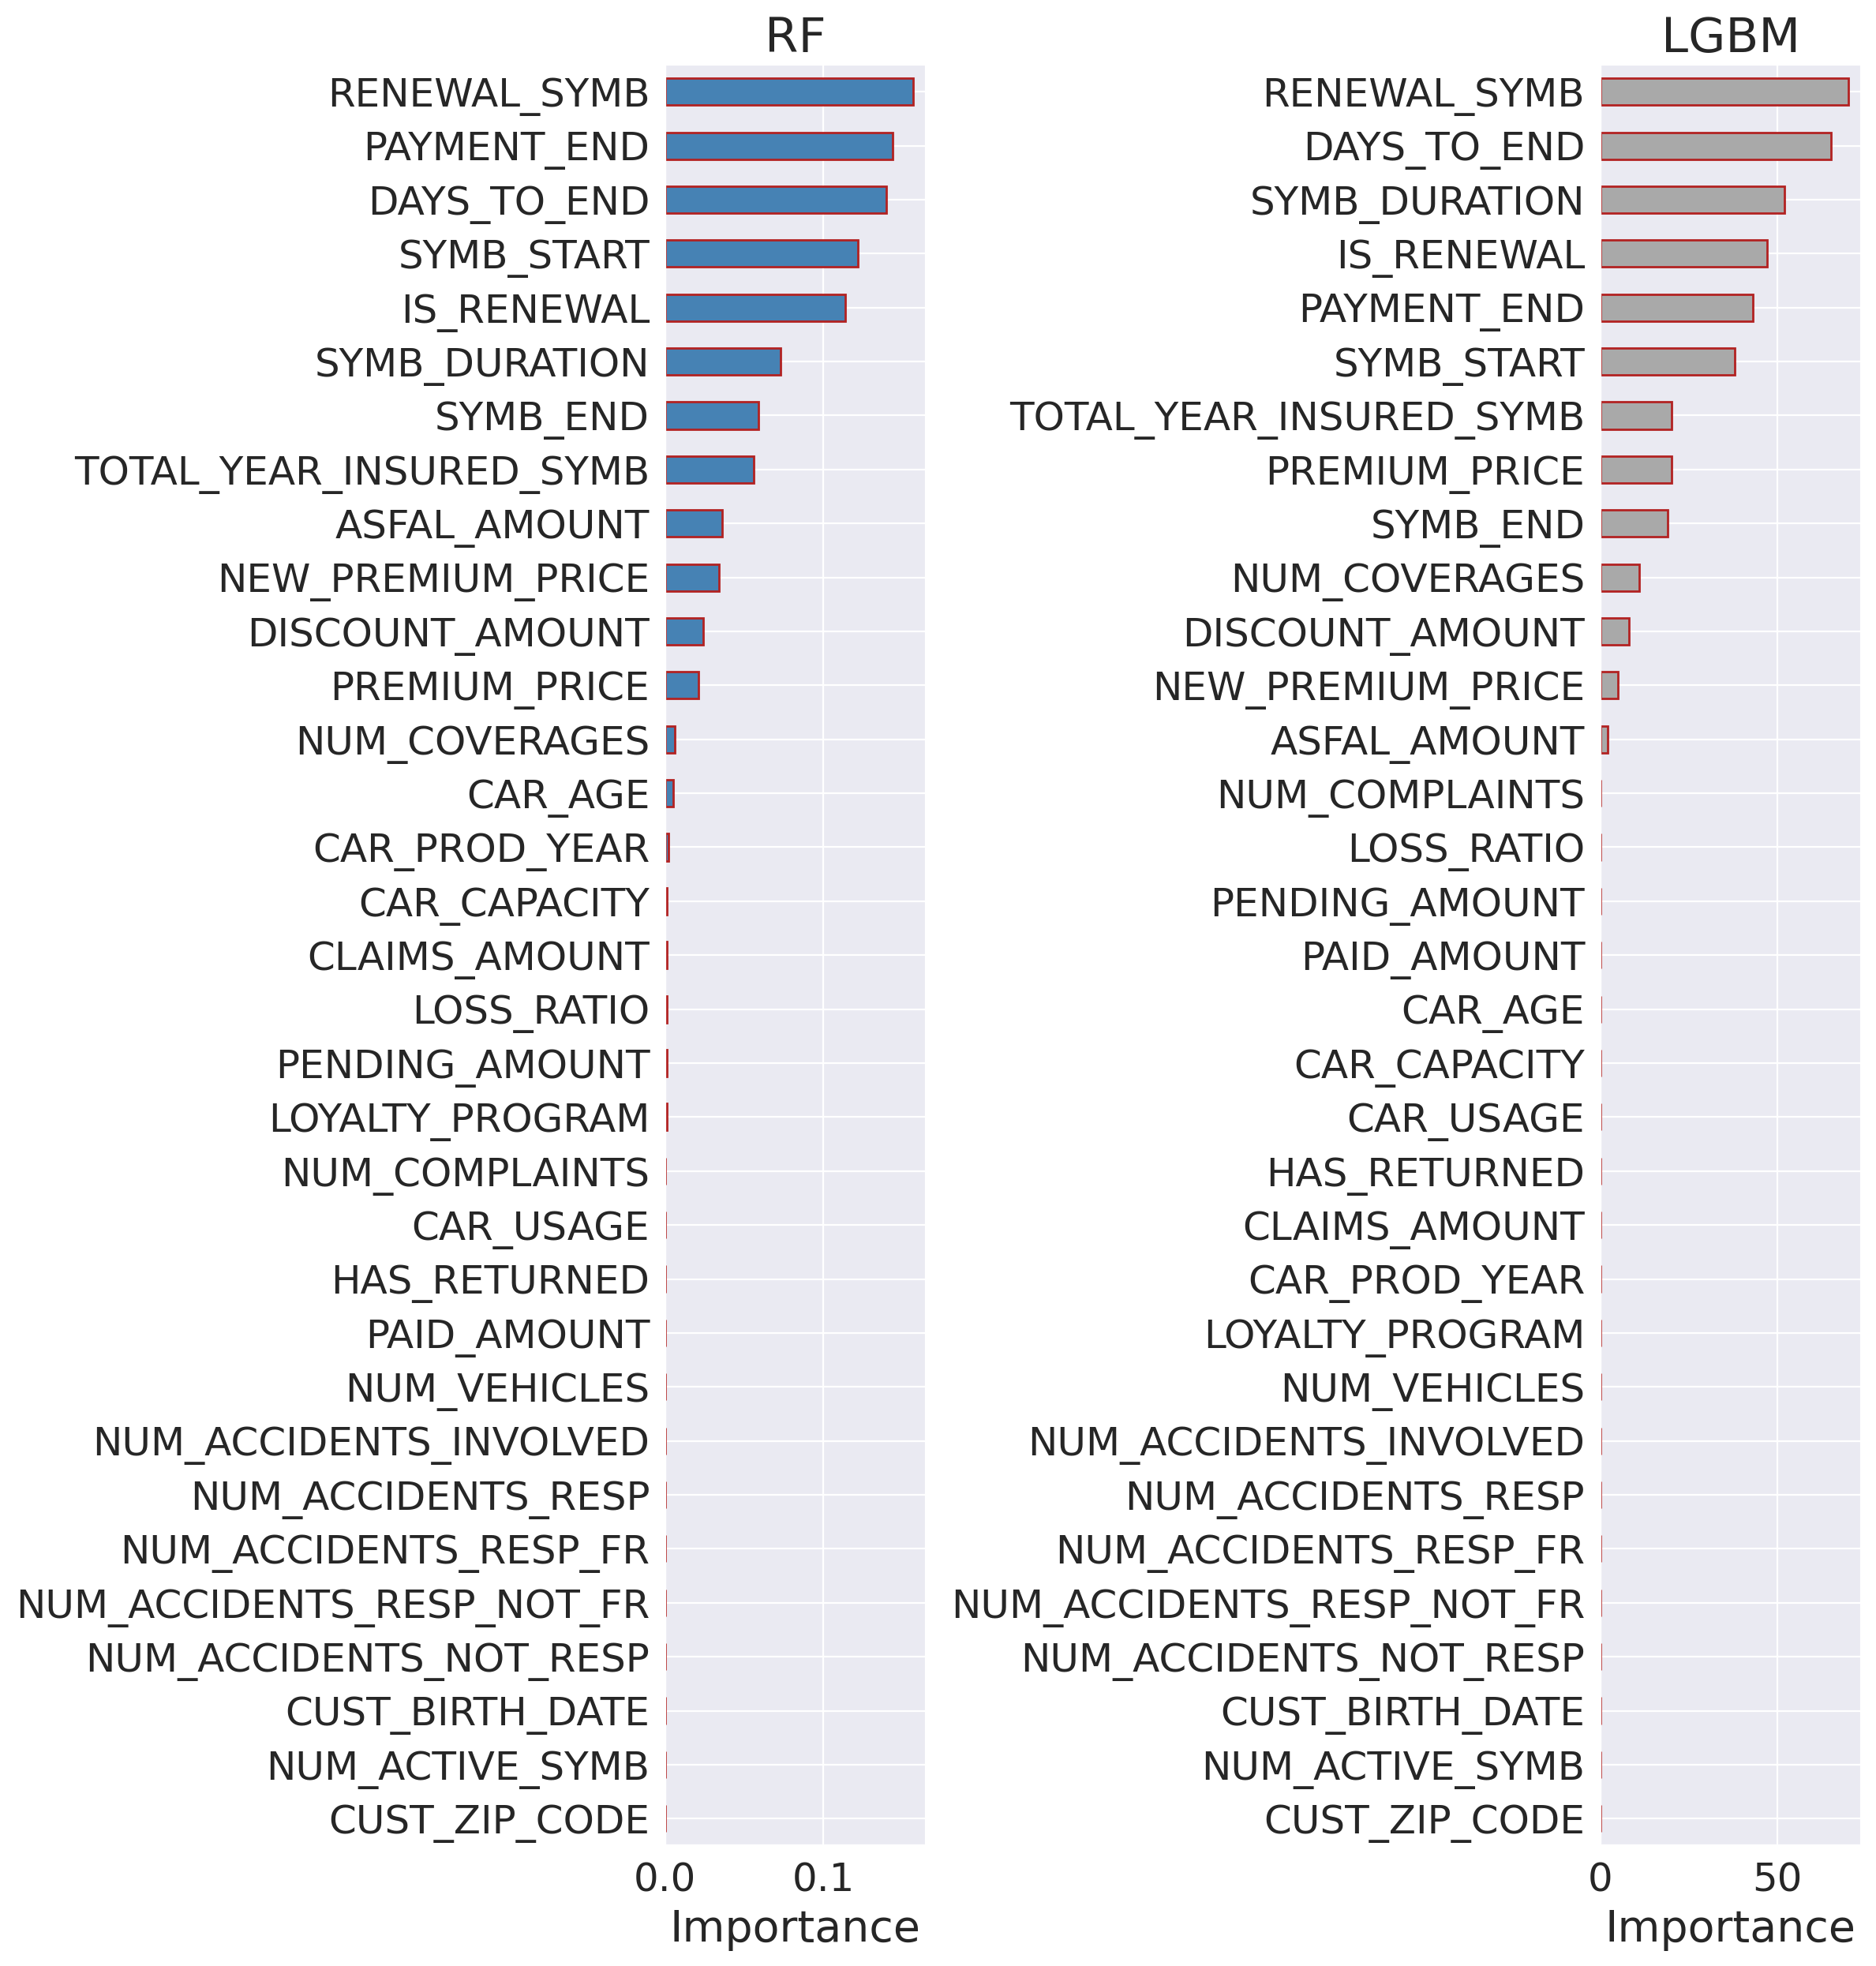

In [29]:
colors_fi = ['steelblue', 'darkgray']

fig = plt.subplots(1, 2, figsize=(12, 24))

for i, (name, clf) in enumerate(zip(['RF', 'LGBM'],
                                    [best_rf_clf, best_lgbmc_clf])):

    ax = plt.subplot(2, 2, i + 1)
    plot_feature_imp(clf, name, colors_fi[i], ax)
    plt.ylabel('')

plt.tight_layout();

Testing

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


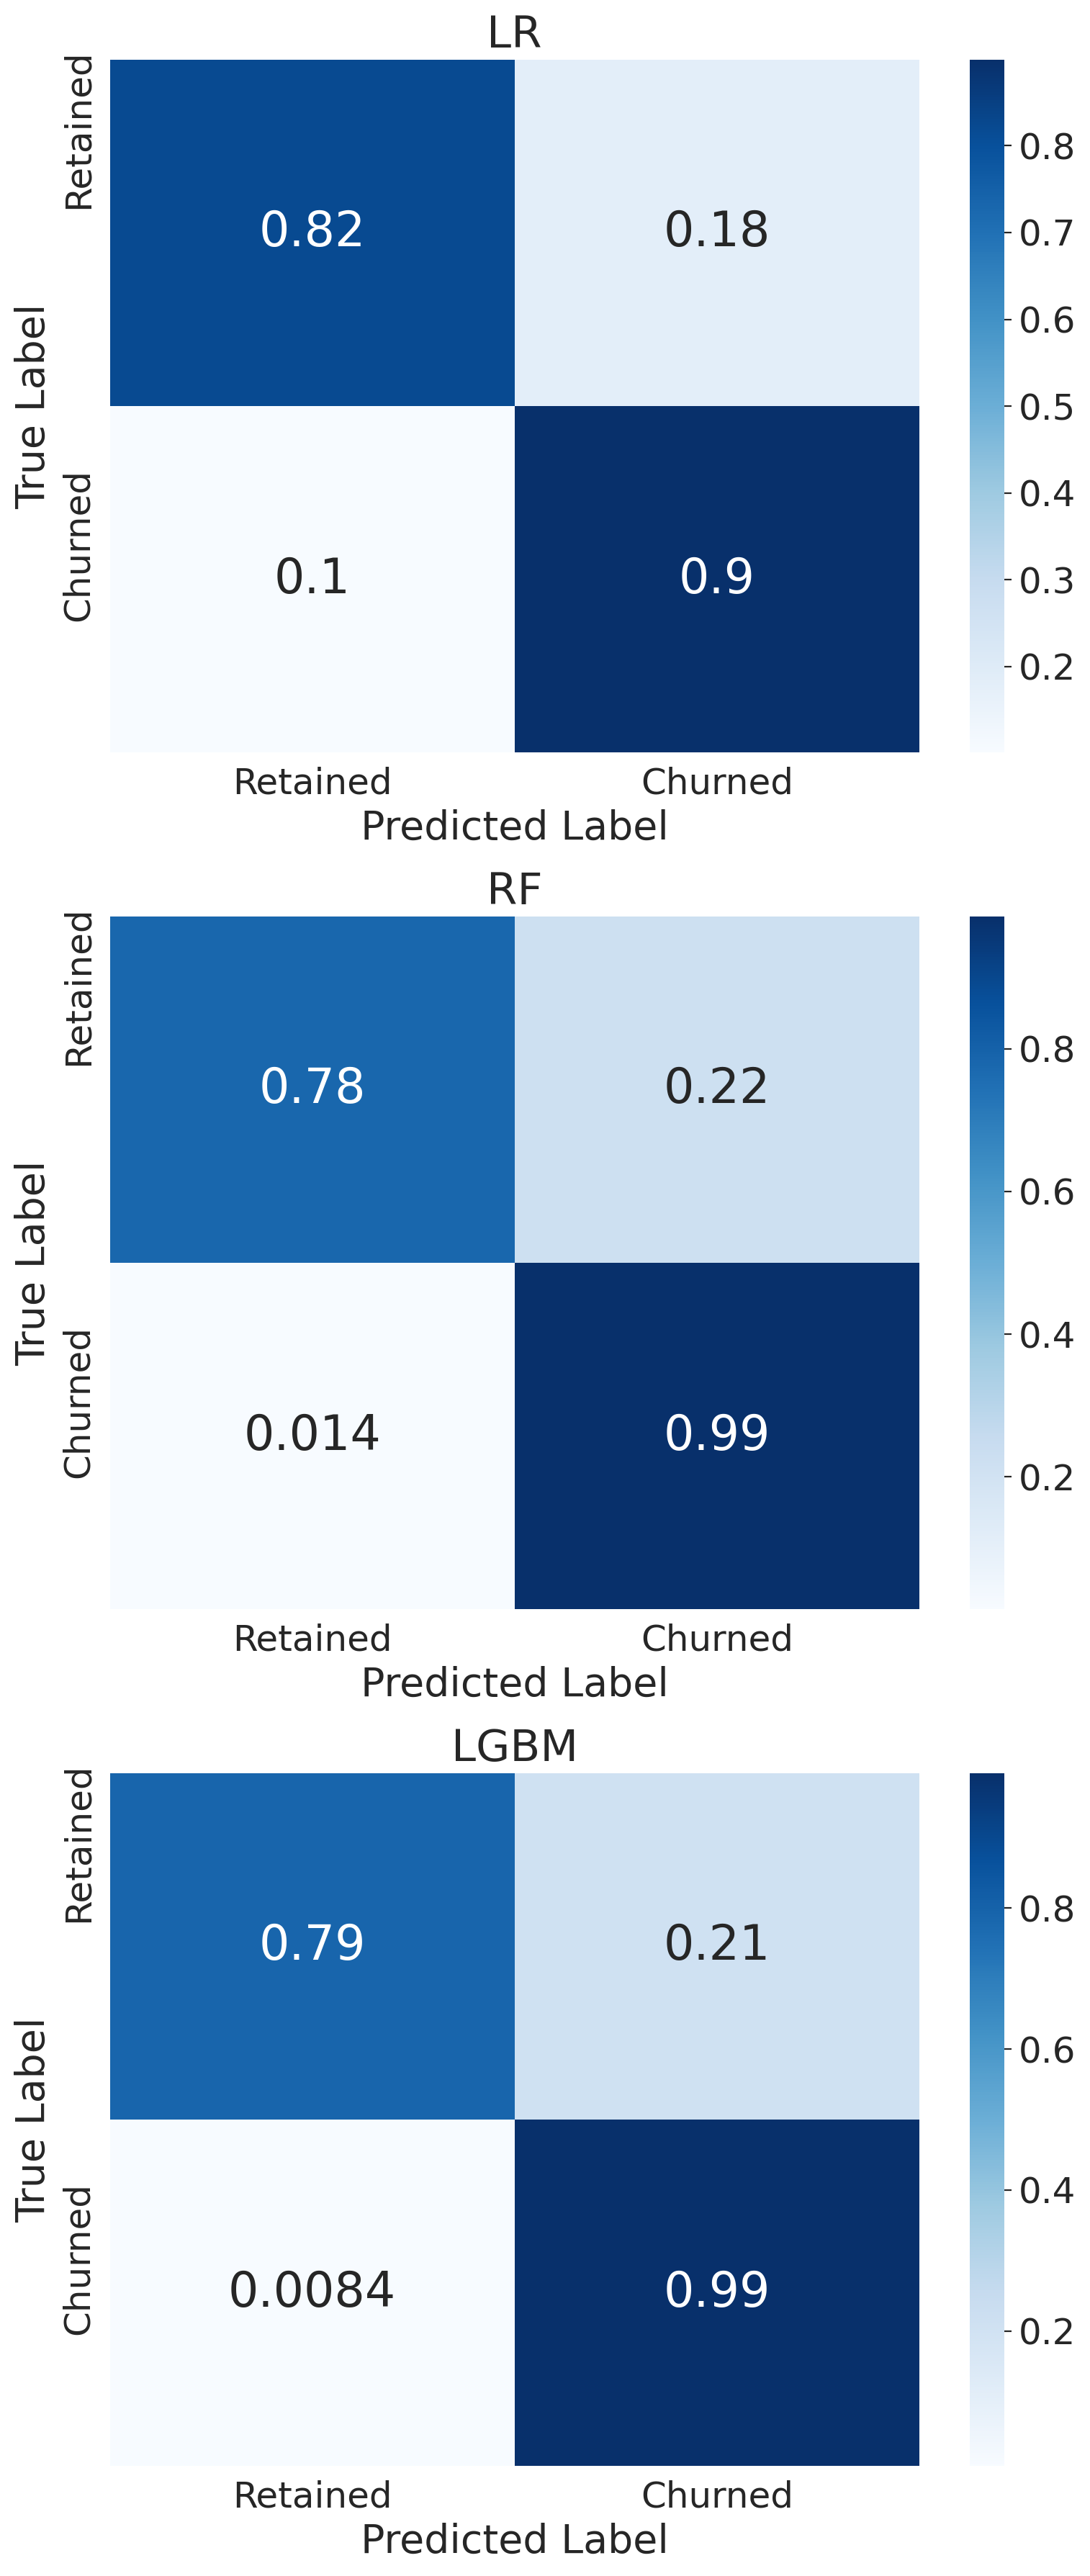

In [30]:
fig, ax = plt.subplots(3, 1, figsize=(8, 18))

for i, (name, clf) in enumerate(zip(['LR', 'RF', 'LGBM'], 
                                    [best_lr_clf.best_estimator_,
                                     best_rf_clf.best_estimator_,
                                     best_lgbmc_clf.best_estimator_])):
    test_func(clf, name, ax=ax[i])

plt.tight_layout()